# Turing Target Practice

## Model

In [1]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [2]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [3]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [4]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [5]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [6]:
target = TuringTarget(stat_model);

In [7]:
spl = MCHMC(0.0, 0.0; init_eps=0.07, varE_wanted=0.01, sigma=ones(2))
samples_mchmc = Sample(spl, target, 100_000;
                       burn_in=1_000,  
                       file_name="Turing_sequential_samples",
                       dialog=true);

Initial Virial loss: 6621.985315873456

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Initial nu 0.2281016476686452
[ Info: Starting burn in ⏳



Virial loss: 108.03489756084893 --> Relative improvement: 0.9836854217568438
Virial loss: 81.37233051749892 --> Relative improvement: 0.2467958747156931
Virial loss: 45.33357104464385 --> Relative improvement: 0.44288714903040693
Virial loss: 0.051713063884589516 --> Relative improvement: 0.998859276631138
Using eps tuning method AdaptiveStep


[ Info: Virial loss condition met during burn-in at step: 4


eps: 0.07 --> VarE/d: 28.365892700125816
eps: 0.02386028017129336 --> VarE/d: 0.10297145683803592
eps: 0.018508661493211766 --> VarE/d: 0.18391766379589072
eps: 0.015282243249720578 --> VarE/d: 0.12003631797487241
eps: 0.01350867578062537 --> VarE/d: 0.1915345840077371
eps: 0.01206126092648709 --> VarE/d: 0.06192143259548775
eps: 0.011331740854353917 --> VarE/d: 0.004235530906192603
eps: 0.011629815159638221 --> VarE/d: 0.0053234910944022626
eps: 0.011826254703550315 --> VarE/d: 0.0015105253753072252
eps: 0.012347849446252451 --> VarE/d: 0.00031339101819443
eps: 0.013176793974214493 --> VarE/d: 0.013407576032168134
eps: 0.013098811216566683 --> VarE/d: 0.03335556160382299
eps: 0.012811794435846697 --> VarE/d: 0.03843388444039838
eps: 0.012520319147870064 --> VarE/d: 0.00024622510279146694
eps: 0.013178311565969417 --> VarE/d: 0.011125673804332813
eps: 0.013156170180091128 --> VarE/d: 0.028019219660818013
eps: 0.012957883251821595 --> VarE/d: 0.003475502843017931
eps: 0.0131515654107146

[ Info: Found eps: 0.015344855962900758 ✅


samples: 100--> 1/<1/ess>: 0.018718503551508284
samples: 203--> 1/<1/ess>: 0.00839558254913463
samples: 310--> 1/<1/ess>: 0.006950886177528786
samples: 420--> 1/<1/ess>: 0.00902093939904976
samples: 534--> 1/<1/ess>: 0.01102355525949104
samples: 652--> 1/<1/ess>: 0.009912729284855891
samples: 774--> 1/<1/ess>: 0.013309612622609454


[ Info: Found L: 0.46116611799306534 ✅
[ Info: Final nu 0.18548899332397398


In [8]:
std(samples_mchmc)[1:end-2]

2-element Vector{Float64}:
 0.04406496403679811
 0.04317242010578533

In [9]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

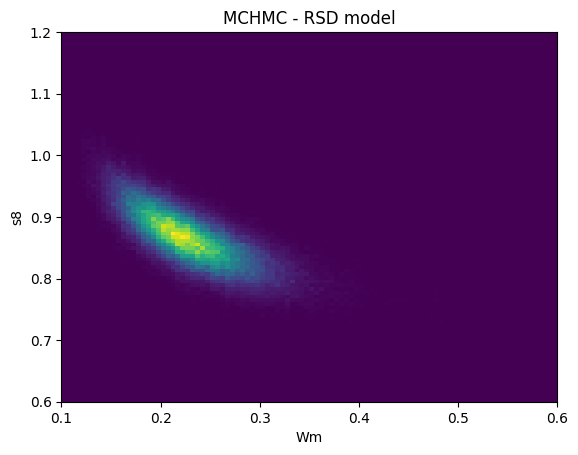

In [10]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [11]:
spl = MCHMC(0.0, 0.5, 10; init_eps=0.07, varE_wanted=0.1)
samples_ensemble_mchmc = Sample(spl, target, 10000;
                                burn_in=1000,
                                monitor_energy=true, 
                                dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Using given L ✅
[ Info: Initial nu 0.4019513728906998
[ Info: Starting burn in ⏳


Initial Virial loss: 20649.493142581163
Virial loss: 100.568341959288 --> Relative improvement: 0.9951297428336434
Virial loss: 97.58450448308523 --> Relative improvement: 0.029669749128514944
Virial loss: 48.60220003773575 --> Relative improvement: 0.5019475653928211
Virial loss: 31.980282476897578 --> Relative improvement: 0.34199928291173176
Virial loss: 21.46049422612018 --> Relative improvement: 0.32894607039124346
Virial loss: 19.6161713755127 --> Relative improvement: 0.08594037169762392
Virial loss: 18.491094773200622 --> Relative improvement: 0.05735454593940459
Virial loss: 16.051509826400228 --> Relative improvement: 0.13193296431188684


┌ Warning: Maximum number of steps reached during burn-in
└ @ MicroCanonicalHMC ~/Glamdring/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:247
[ Info: Found sigma: [0.9971489379931034, 0.07545856783179773] ✅


Using eps tuning method AdaptiveStep
eps: 0.07 --> VarE/d: 0.3828114661854275
eps: 0.057101490962959946 --> VarE/d: 0.6353371431183084
eps: 0.0492363301012363 --> VarE/d: 0.4697581990114338
eps: 0.045141635652877966 --> VarE/d: 0.3935170823187012
eps: 0.04253098086021463 --> VarE/d: 0.34645554622770863
eps: 0.040684345155577555 --> VarE/d: 0.2965205697476566
eps: 0.03935662323264939 --> VarE/d: 0.2698980149253696
eps: 0.03832527644403841 --> VarE/d: 0.27071511849095964
eps: 0.037425649532999344 --> VarE/d: 0.24455102787384414
eps: 0.0367078154466591 --> VarE/d: 0.23186105639403537
eps: 0.03609928565437652 --> VarE/d: 0.22889293594317334
eps: 0.03555314222544423 --> VarE/d: 0.21649074652386768
eps: 0.035083831672634874 --> VarE/d: 0.21731548130765485
eps: 0.03464630498354503 --> VarE/d: 0.2146524833299123
eps: 0.034244058209233486 --> VarE/d: 0.21902341919697724
eps: 0.033856446075960736 --> VarE/d: 0.2187772929365385
eps: 0.03349115848447148 --> VarE/d: 0.2233591704190187
eps: 0.033135

[ Info: Final nu 0.21122421525168825


In [12]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

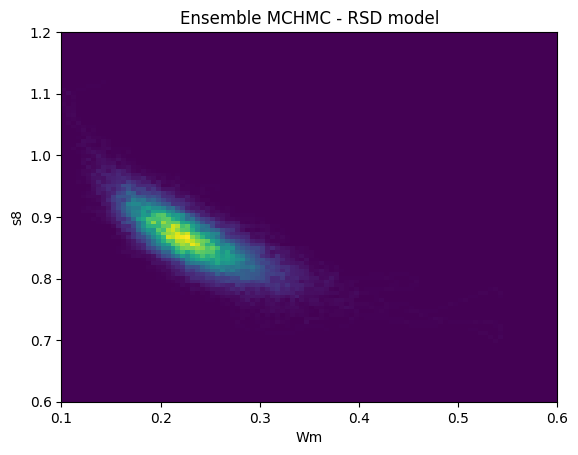

In [13]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [14]:
spl = MCHMC(0.0, 0.0; init_eps=0.07, varE_wanted=0.01, sigma=ones(2))
samples = sample(
    stat_model, spl, 10_000; burn_in=1_000,
    dialog=true)

Initial Virial loss: 924342.1487563013
Virial loss: 821.594310992149 --> Relative improvement: 0.9991111577979024
Virial loss: 691.360324009966 --> Relative improvement: 0.15851373998064044
Virial loss: 570.7252657084764 --> Relative improvement: 0.17448941472630797
Virial loss: 459.68921941857724 --> Relative improvement: 0.19455253334905942
Virial loss: 358.25227078510943 --> Relative improvement: 0.22066418864851123
Virial loss: 266.414517809381 --> Relative improvement: 0.256349395286361
Virial loss: 184.1761001664849 --> Relative improvement: 0.3086859466935563
Virial loss: 111.53730555330577 --> Relative improvement: 0.39439859214913187
Virial loss: 48.499123630257216 --> Relative improvement: 0.5651757643806576
Virial loss: 4.934561837918662 --> Relative improvement: 0.898254618464072
Virial loss: 0.9447374832735016 --> Relative improvement: 0.8085468346928285
Using eps tuning method AdaptiveStep
eps: 0.07 --> VarE/d: 0.0072203800302516104
eps: 0.07355331119137712 --> VarE/d: 8.

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Initial nu 0.2281016476686452
[ Info: Starting burn in ⏳
[ Info: Virial loss condition met during burn-in at step: 30
[ Info: Found eps: 0.016270302370808738 ✅


samples: 1445--> 1/<1/ess>: 0.005744436603283922
samples: 1593--> 1/<1/ess>: 0.0056481565923256075
samples: 1746--> 1/<1/ess>: 0.005901385442137528


[ Info: Found L: 1.102812383996088 ✅
[ Info: Final nu 0.1223653752171508
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.3 seconds
Compute duration  = 2.3 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2278    0.0429     0.0004    0.0030   160.8598    1.0014     ⋯
          σ8    0.8677    0.0424     0.0004    0.0022   348.4467    1.0000     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1542    0.1965    0.2242    0.2544    0.3232
          σ8    0.7889    0.8385    0.8661    0.8949    0.9544


In [15]:
new_samples = sample(stat_model, spl, 10000; burn_in=1_000,
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.92 seconds
Compute duration  = 0.92 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2311    0.0456     0.0005    0.0033   150.7059    1.0008     ⋯
          σ8    0.8654    0.0437     0.0004    0.0024   308.6740    1.0014     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1546    0.1978    0.2272    0.2580    0.3357
          σ8    0.7832    0.8348    0.8640    0.8942    0.9548


## Ensemble AbstractMCMC

In [16]:
spl = MCHMC(0.0, 0.0, 10; init_eps=0.07, varE_wanted=0.1)
samples = sample(stat_model, spl, 10_000; burn_in=1_000)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Initial nu 0.2281016476686452
[ Info: Starting burn in ⏳
[ Info: Virial loss condition met during burn-in at step: 309
[ Info: Found sigma: [0.9950812761520736, 0.09906186880712892] ✅
[ Info: Found eps: 0.02801917699433691 ✅


Hello


[ Info: Found L: 0.00015905687530696946 ✅
[ Info: Final nu 2.2595945333701965e76


World


Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:05


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1001:1:101000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 5.44 seconds
Compute duration  = 5.44 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2832    0.1504     0.0005    0.0084   202.9195    1.1225     ⋯
          σ8    0.8754    0.1613     0.0005    0.0090   202.7818    1.1470     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.0340    0.1705    0.2774    0.4121    0.5093
          σ8    0.6855    0.7531    0.8399    0.9280    1.2572


In [17]:
samples = sample(stat_model, spl, 10_000; burn_in=1_000)

LoadError: MethodError: no method matching sample(::DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}, ::Int64, ::Int64, ::Int64; resume_from::Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:target, :sampler, :init, :start_time, :stop_time), Tuple{ParallelTarget, MicroCanonicalHMC.EnsembleSampler, Tuple{Tuple{Matrix{Float64}, Matrix{Float64}, Vector{Real}, Matrix{Real}, Vector{Float64}}, Tuple{Matrix{Real}, Vector{Float64}, Vector{Float64}}}, Float64, Float64}}})

[0mClosest candidates are:
[0m  sample(::AbstractMCMC.AbstractModel, [91m::Turing.Inference.InferenceAlgorithm[39m, [91m::AbstractMCMC.AbstractMCMCEnsemble[39m, ::Integer, [91m::Integer[39m; kwargs...)
[0m[90m   @[39m [32mTuring[39m [90m~/.julia/packages/Turing/b6CoW/src/inference/[39m[90m[4mInference.jl:185[24m[39m
[0m  sample(::AbstractMCMC.AbstractModel, [91m::Turing.Inference.InferenceAlgorithm[39m, ::Integer; kwargs...)
[0m[90m   @[39m [32mTuring[39m [90m~/.julia/packages/Turing/b6CoW/src/inference/[39m[90m[4mInference.jl:130[24m[39m
[0m  sample([91m::Random.AbstractRNG[39m, ::Any, [91m::AbstractMCMC.AbstractSampler[39m, ::Any; kwargs...)
[0m[90m   @[39m [36mAbstractMCMC[39m [90m~/.julia/packages/AbstractMCMC/F9Hbk/src/[39m[90m[4mlogdensityproblems.jl:43[24m[39m
[0m  ...


## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: number of chains: 4 smaller than number of threads: 10. Increase the number of chains to make full use of your threads.


Using eps tuning method AdaptiveStep
Using eps tuning method AdaptiveStep
Using eps tuning method AdaptiveStep
Using eps tuning method AdaptiveStep


[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Initial nu 0.7169780267370375
[ Info: Initial nu 0.7169780267370375
[ Info: Tuning L ⏳
[ Info: Initial nu 0.7169780267370375
[ Info: Tuning L ⏳
[ Info: Initial nu 0.7169780267370375


eps: 0.5 --> VarE/d: 73324.60159259173
eps: 0.5 --> VarE/d: 32784.143678330496
eps: 0.5 --> VarE/d: 79066.92925701289
eps: 0.14883750126249298 --> VarE/d: 1433.9492975733203
eps: 0.15160430658252794 --> VarE/d: 121.29387275214957
eps: 0.07326115392741621 --> VarE/d: 17.27880850437378
eps: 0.5 --> VarE/d: 114494.18762713153
eps: 0.14878547798291655 --> VarE/d: 3788.0590364257932
eps: 0.0944208298019469 --> VarE/d: 5.572357031904864
eps: 0.06044664008259043 --> VarE/d: 0.4664106540361505
eps: 0.06944380551916152 --> VarE/d: 272.37846031740355
eps: 0.08709532314611322 --> VarE/d: 0.3709675559799347
eps: 0.0660567292980414 --> VarE/d: 12.03223490593252
eps: 0.14907716056831255 --> VarE/d: 5009.634114616097
eps: 0.04616185289018221 --> VarE/d: 43.88486085716352
eps: 0.0954007957016898 --> VarE/d: 4.209671550037627
eps: 0.06088327405993844 --> VarE/d: 0.7697523504380986
eps: 0.037792275498860564 --> VarE/d: 7.091923598848533
eps: 0.06311931662137858 --> VarE/d: 0.0036656226512053846
eps: 0.0

[ Info: Found eps: 0.0932115075362089 ✅
[ Info: Found eps: 0.08092777669433035 ✅
[ Info: Found eps: 0.07455418936907099 ✅


samples: 100--> 1/<1/ess>: 0.08355472002026507
samples: 100--> 1/<1/ess>: 0.029067288735138468
samples: 100--> 1/<1/ess>: 0.02416389319956664
samples: 100--> 1/<1/ess>: 0.020738666875957486
samples: 203--> 1/<1/ess>: 0.008988571090007813
samples: 203--> 1/<1/ess>: 0.07055009782765168
samples: 203--> 1/<1/ess>: 0.011121175069401329
samples: 203--> 1/<1/ess>: 0.04267327024594129
samples: 310--> 1/<1/ess>: 0.008528341771858077
samples: 310--> 1/<1/ess>: 0.017414548623533845
samples: 310--> 1/<1/ess>: 0.07259302076227203
samples: 420--> 1/<1/ess>: 0.010815763494413756
samples: 420--> 1/<1/ess>: 0.019246641789046597
samples: 534--> 1/<1/ess>: 0.012206551853221594
samples: 534--> 1/<1/ess>: 0.038778922711604935
samples: 652--> 1/<1/ess>: 0.011032483142250396


[ Info: Found L: 0.528484072489409 ✅
[ Info: Final nu 0.45987827256513897
[ Info: Found L: 0.4459259352733262 ✅
[ Info: Final nu 0.46775297546055017
[ Info: Found L: 1.1646474339365367 ✅
[ Info: Final nu 0.32708434723369145


samples: 774--> 1/<1/ess>: 0.01070862652716927
samples: 900--> 1/<1/ess>: 0.0117331435387923


[ Info: Found L: 2.5416612052031504 ✅
[ Info: Final nu 0.1738112505102541


LoadError: TaskFailedException

[91m    nested task error: [39mUndefVarError: `sample` not defined
    Stacktrace:
     [1] [0m[1mtune_hyperparameters[22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget, [90minit[39m::[0mTuple[90m{Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Float64}[39m; [90mburn_in[39m::[0mInt64, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m   @[39m [32mMicroCanonicalHMC[39m [90m~/Glamdring/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:304[24m[39m
     [2] [0m[1mmacro expansion[22m
    [90m   @[39m [90m~/Glamdring/MicroCanonicalHMC.jl/src/[39m[90m[4mabstractmcmc.jl:220[24m[39m[90m [inlined][39m
     [3] [0m[1m(::MicroCanonicalHMC.var"#1050#threadsfor_fun#94"{MicroCanonicalHMC.var"#1050#threadsfor_fun#83#95"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [32mMicroCanonicalHMC[39m [90m./[39m[90m[4mthreadingconstructs.jl:139[24m[39m
     [4] [0m[1m#1050#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:106[24m[39m[90m [inlined][39m
     [5] [0m[1m(::Base.Threads.var"#1#2"{MicroCanonicalHMC.var"#1050#threadsfor_fun#94"{MicroCanonicalHMC.var"#1050#threadsfor_fun#83#95"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m

...and 3 more exceptions.


In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run


LoadError: MethodError: no method matching iterate(::Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:target, :sampler, :init, :start_time, :stop_time), Tuple{ParallelTarget, MicroCanonicalHMC.EnsembleSampler, Tuple{Tuple{Matrix{Float64}, Matrix{Float64}, Vector{Real}, Matrix{Real}, Vector{Float64}}, Tuple{Matrix{Real}, Vector{Float64}, Vector{Float64}}}, Float64, Float64}}})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.66 seconds
Compute duration  = 11.66 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2403    0.0683     0.0007    0.0017   1405.0343    1.0006    ⋯
          σ8    0.8637    0.0619     0.0006    0.0012   2356.8676    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.195289  0.931189  15.6471   7.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.194965  0.891184  16.194    3.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.20792   0.883536  16.2748  15.0  1.0     3.0  0.0  0.0471045  0.0471045
 0.252361  0.838644  16.1968  31.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.251986  0.825046  16.0557   1.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.24801   0.831916  16.1395   3.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.195668  0.864144  15.9732  21.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.264617  0.863147  15.8853  19.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.272399  0.787847  15.258    7.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

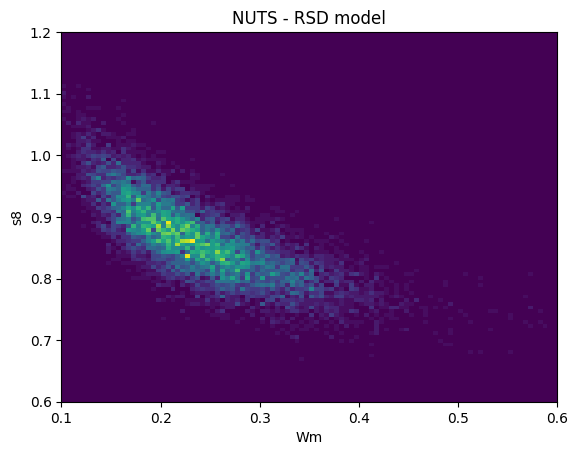

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");